In [7]:
import mldaikon
import os
import polars as pl

trace_files = [file_name for file_name in os.listdir() if "_trace_" in file_name]
print(trace_files)

['_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2198023.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-44_2198021.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2198905.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-44_2199157.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-44_2198020.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-44_2199173.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2199178.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2199002.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2198026.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-45_2199160.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_VAR_2024-05-02_14-54-45_2198024.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_VAR_2024-05-02_14-54-44_2198025.log', '_ml_daikon_pretrain_gpt_mldaikon_trace_API_2024-05-02_14-54-44

In [8]:
import mldaikon.ml_daikon_trace

trace = mldaikon.ml_daikon_trace.read_trace_file(trace_files)

In [9]:
from typing import NamedTuple
import json

class VarId(NamedTuple):
    process_id: int
    var_name: str
    var_type: str

class PropState(NamedTuple):
    value: type
    timestamp: int


var_ids = trace.find_variable_identifiers()
# for each of such variables, let's construct their prop states
var_prop_values = {}


prop_prefix = "change.properties.new."
value_prefix = "change.value.new"

for var_id in var_ids.rows(named=True):
    var_values = trace.events.filter(
        pl.col('process_id') == var_id['process_id'],
        pl.col('var_name') == var_id['var_name'],
        pl.col('var_type') == var_id['var_type']
    )

    state_init = var_values.filter(pl.col('type') == 'state_init')
    assert len(state_init) == 1, f"Expected 1 state_init event, got {len(state_init)}"
    state_init = state_init.row(0, named=True)

    state_changes = var_values.filter(pl.col('type') == 'state_change')
    
    # init prop values for this variable
    prop_values = {}
    for column in state_init:
        if column.startswith(prop_prefix):
            prop_values[column.split(prop_prefix)[-1]] = [PropState(state_init[column], state_init['time'])]
        if column.startswith(value_prefix):
            prop_values['param_value'] = [PropState(state_init[column], state_init['time'])]
    
    for state_change in state_changes.rows(named=True):
        for prop_value in state_change:
            if prop_value.startswith(prop_prefix) and state_change[prop_value] != prop_values[prop_value.split(prop_prefix)[-1]][-1].value and state_change[prop_value] is not None:
                prop_values[prop_value.split(prop_prefix)[-1]].append(PropState(state_change[prop_value], state_change['time']))
            if (prop_value.startswith(value_prefix) 
                and state_change[prop_value] != prop_values['param_value'][-1].value) and state_change[prop_value] is not None:
                prop_values['param_value'].append(PropState(state_change[prop_value], state_change['time']))

    var_prop_values[VarId(var_id['process_id'], var_id['var_name'], var_id['var_type'])] = prop_values

In [10]:
from tqdm import tqdm

class Liveness(NamedTuple):
    start: float
    end: float

def compare(value1, value2):
    if type(value1) != type(value2):
        return False
    if isinstance(value1, list):
        if len(value1) != len(value2):
            return False
        for idx, val in enumerate(value1):
            if not compare(val, value2[idx]):
                return False
        return True
    if isinstance(value1, dict):
        if len(value1) != len(value2):
            return False
        for key in value1:
            if key not in value2:
                return False
            if not compare(value1[key], value2[key]):
                return False
        return True
    if isinstance(value1, float):
        return abs(value1 - value2) < 1e-6
    return value1 == value2

    # if numerical, compare with tolerance
    # if collections, compare and aggregate the results

hypothesis = {}  # key: (var1, prop1, var2, prop2), value: list of liveness intervals
# Liveness based Hypothesis generation
for var in tqdm(var_prop_values):
    prop_values = var_prop_values[var]
    for prop in prop_values:
        for other_var in var_prop_values:
            for other_prop in var_prop_values[other_var]:
                if other_var == var and other_prop == prop:
                    continue

                # if the type of the property is not the same, we can't compare them
                if type(prop_values[prop][0].value) != type(var_prop_values[other_var][other_prop][0].value):
                    continue
                
                for idx, value in enumerate(prop_values[prop]):
                    start = value.timestamp
                    end = float('inf')
                    if idx + 1 < len(prop_values[prop]):
                        end = prop_values[prop][idx + 1].timestamp
                    liveness = Liveness(start, end)
                    for other_idx, other_value in enumerate(var_prop_values[other_var][other_prop]):
                        other_start = other_value.timestamp
                        other_end = float('inf')
                        if other_idx + 1 < len(var_prop_values[other_var][other_prop]):
                            other_end = var_prop_values[other_var][other_prop][other_idx + 1].timestamp
                        other_liveness = Liveness(other_start, other_end)
                        if (liveness.start > other_liveness.start or liveness.end < other_liveness.end):
                            # no overlap between the liveness of the two properties, skipping
                            continue
                        
                        # in the hypothesis, we don't want to include the process_id as the final invariant should be independent of the specific process id but focus on behavior of the type
                        var_id_new = VarId(-1, var.var_name, var.var_type)
                        other_var_id_new = VarId(-1, other_var.var_name, other_var.var_type)
                        if compare(value.value, other_value.value):
                            if (var_id_new, prop, other_var_id_new, other_prop) not in hypothesis and (other_var_id_new, other_prop, var_id_new, prop) not in hypothesis:
                                hypothesis[(var_id_new, prop, other_var_id_new, other_prop)] = []
                            if (var_id_new, prop, other_var_id_new, other_prop) in hypothesis:
                                hypothesis[(var_id_new, prop, other_var_id_new, other_prop)].append((liveness, other_liveness))
                            else:
                                hypothesis[(other_var_id_new, other_prop, var_id_new, prop)].append((other_liveness, liveness))

  0%|          | 0/416 [00:00<?, ?it/s]

100%|██████████| 416/416 [11:43<00:00,  1.69s/it]


In [11]:
print(len(hypothesis))

606943


In [8]:
def compare(value1, value2):
    if type(value1) != type(value2):
        return False
    if isinstance(value1, list):
        if len(value1) != len(value2):
            return False
        for idx, val in enumerate(value1):
            if not compare(val, value2[idx]):
                return False
        return True
    if isinstance(value1, dict):
        if len(value1) != len(value2):
            return False
        for key in value1:
            if key not in value2:
                return False
            if not compare(value1[key], value2[key]):
                return False
        return True
    if isinstance(value1, float):
        return abs(value1 - value2) < 1e-6
    return value1 == value2

var_prop_values[list(var_prop_values.keys())[0]].keys()
compare(var_prop_values[list(var_prop_values.keys())[0]]['param_value'][1].value, var_prop_values[list(var_prop_values.keys())[0]]['shape'][0].value)

False

In [5]:
var_prop_values[list(var_prop_values.keys())[0]]['param_value'][-1]

PropState(value=[[0.000492095947265625, -0.0003795623779296875, 0.000514984130859375, -0.000637054443359375, -0.0004596710205078125, 0.00014209747314453125, 0.0003108978271484375, -0.000675201416015625, -2.5033950805664062e-06, 4.675239324569702e-07, -5.811452865600586e-07, 1.1846423149108887e-06, -1.4454126358032227e-06, -2.384185791015625e-06, -2.7418136596679688e-06, -1.30385160446167e-07, 0.00102996826171875, -0.000629425048828125, 0.000492095947265625, -0.000576019287109375, -0.000408172607421875, 0.000522613525390625, -0.00054931640625, 0.00067138671875, 0.00086212158203125, -0.000652313232421875, 0.000621795654296875, 0.000614166259765625, -0.000652313232421875, 0.00017547607421875, -0.0005645751953125, -0.000682830810546875, 3.0994415283203125e-06, 3.073364496231079e-07, 1.1399388313293457e-06, 5.103647708892822e-07, 1.601874828338623e-06, -1.30385160446167e-06, 1.2740492820739746e-06, 1.475214958190918e-06, -0.000537872314453125, 0.000560760498046875, 0.00086212158203125, 0.00

In [14]:
len(hypothesis)

606943

In [12]:
# filtered hypothesis based on number of states seen
filtered_hypothesis = {}
num_states = []
for key in hypothesis:
    num_states.append(len(hypothesis[key]))
    if len(hypothesis[key]) > 10 * 8:
        filtered_hypothesis[key] = hypothesis[key]

In [16]:
filtered_hypothesis

{(VarId(process_id=-1, var_name='module.6.input_layernorm.bias', var_type='torch.cuda.BFloat16Tensor'),
  'param_value',
  VarId(process_id=-1, var_name='module.6.input_layernorm.bias', var_type='torch.cuda.BFloat16Tensor'),
  'param_value'): [(Liveness(start=1714676153.27324, end=1714676157.483384),
   Liveness(start=1714676153.290802, end=1714676157.4694)),
  (Liveness(start=1714676169.978618, end=1714676174.271123),
   Liveness(start=1714676169.995782, end=1714676174.256506)),
  (Liveness(start=1714676237.346893, end=1714676241.674203),
   Liveness(start=1714676237.359169, end=1714676241.657477)),
  (Liveness(start=1714676274.88016, end=1714676279.038371),
   Liveness(start=1714676274.892871, end=1714676279.023468)),
  (Liveness(start=1714676283.132096, end=inf),
   Liveness(start=1714676283.144349, end=inf)),
  (Liveness(start=1714676098.131888, end=1714676107.034353),
   Liveness(start=1714676098.131901, end=1714676107.017883)),
  (Liveness(start=1714676153.27839, end=1714676157.4

(array([2.11400e+03, 0.00000e+00, 6.04811e+05, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.80000e+01]),
 array([ 28. ,  44.8,  61.6,  78.4,  95.2, 112. , 128.8, 145.6, 162.4,
        179.2, 196. ]),
 <BarContainer object of 10 artists>)

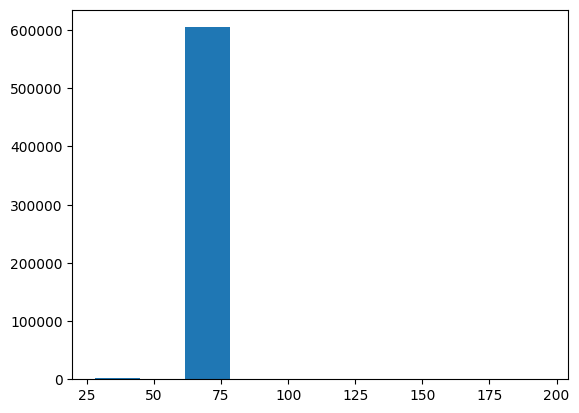

In [13]:
# len(filtered_hypothesis)
max(num_states)

# draw a bin plot of the number of states seen
import matplotlib.pyplot as plt

plt.hist(num_states)



In [28]:
print(min(num_states))

28


In [12]:
filtered_hypothesis

{(VarId(process_id=2198022, var_name='module.5.self_attention.query_key_value.bias', var_type='torch.cuda.BFloat16Tensor'),
  'param_value',
  VarId(process_id=2198026, var_name='module.5.self_attention.query_key_value.bias', var_type='torch.cuda.BFloat16Tensor'),
  'param_value'): [(Liveness(start=1714676107.017993, end=1714676111.189266),
   Liveness(start=1714676107.034353, end=1714676111.189017)),
  (Liveness(start=1714676157.474063, end=1714676161.674848),
   Liveness(start=1714676157.488835, end=1714676161.658455)),
  (Liveness(start=1714676225.023068, end=1714676229.168788),
   Liveness(start=1714676225.038266, end=1714676229.154468)),
  (Liveness(start=1714676241.660012, end=1714676245.907362),
   Liveness(start=1714676241.678982, end=1714676245.900865)),
  (Liveness(start=1714676279.028171, end=1714676283.1495),
   Liveness(start=1714676279.043389, end=1714676283.13659)),
  (Liveness(start=1714676098.13193, end=1714676107.017993),
   Liveness(start=1714676098.131888, end=17146

In [ ]:
# param_selector is a tricky one, because sometimes multiple selectors needs to be selected together based on their liveness